# Given certain aspects about a person, can we predict recidivism both accurately and fairly?

In [1]:
%run "/Users/rileyfox/Code/Feature_Engineering/logger.py"

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
import dalex as dx
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.datasets import BinaryLabelDataset

# EDA

In [3]:
compas_df = pd.read_csv('/Users/rileyfox/Code/Feature_Engineering/Chapter_4/compas-scores-two-years.csv')
                 
compas_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


<AxesSubplot: title={'center': 'Decile Score Histogram by Race'}, xlabel='race', ylabel='% with Decile Score'>

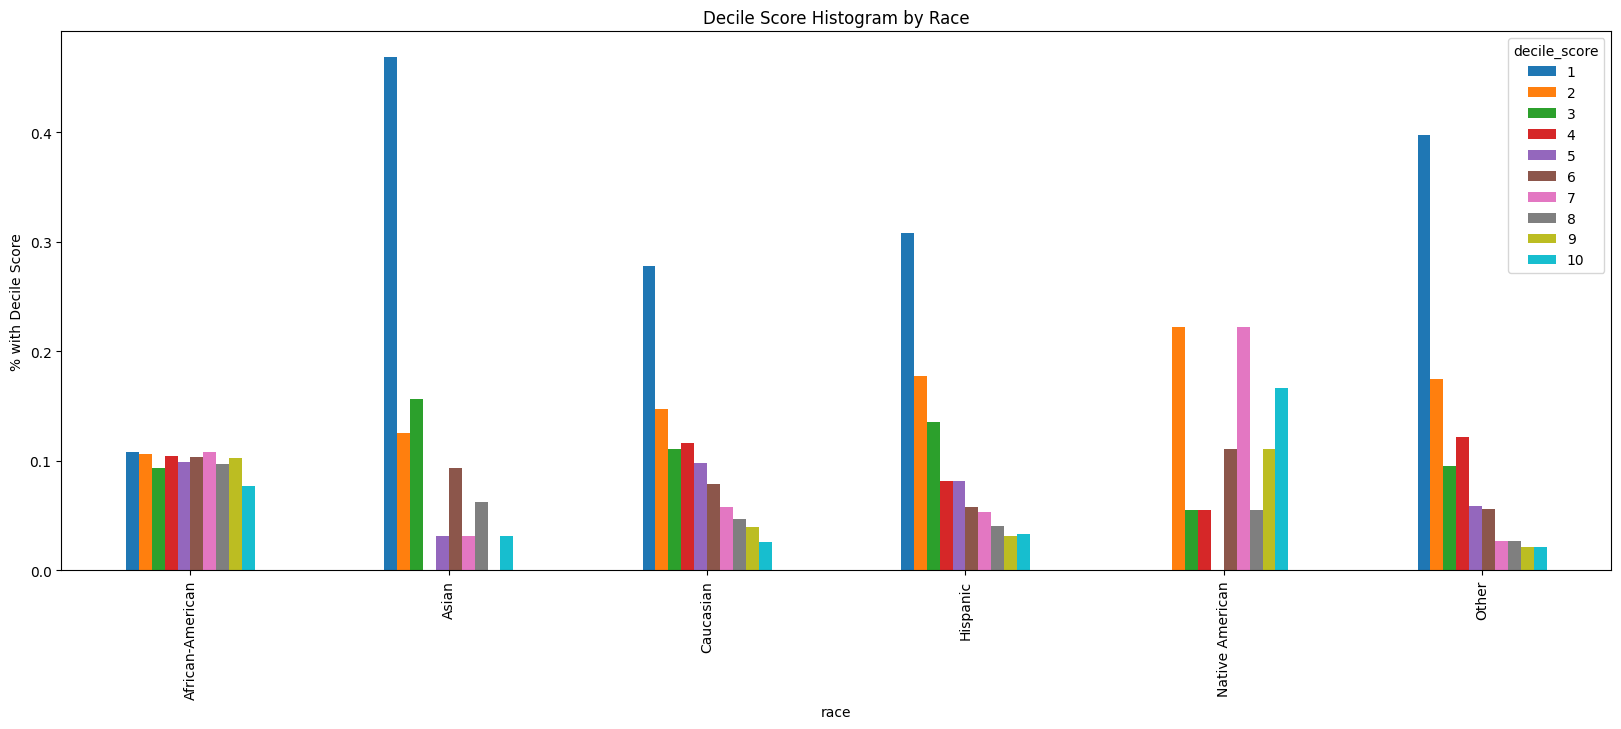

In [4]:
# view distribution of decile scores (10% buckets of recidivism likelihood)
compas_df.groupby('race')['decile_score'].value_counts(normalize=True).unstack().plot(
    kind='bar', figsize=(20, 7),
    title='Decile Score Histogram by Race', ylabel='% with Decile Score'
)

In [5]:
compas_df.groupby('race')['decile_score'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,5.368777,2.831122,1.0,3.00,5.0,8.00,10.0
Asian,32.0,2.937500,2.601953,1.0,1.00,2.0,3.50,10.0
Caucasian,2454.0,3.735126,2.597926,1.0,1.00,3.0,5.00,10.0
Hispanic,637.0,3.463108,2.599100,1.0,1.00,3.0,5.00,10.0
Native American,18.0,6.166667,2.975389,2.0,3.25,7.0,8.75,10.0
Other,377.0,2.949602,2.350895,1.0,1.00,2.0,4.00,10.0


In [6]:
# response variable
compas_df.groupby('race')['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,0.514340,0.499862,0.0,0.0,1.0,1.0,1.0
Asian,32.0,0.281250,0.456803,0.0,0.0,0.0,1.0,1.0
Caucasian,2454.0,0.393643,0.488657,0.0,0.0,0.0,1.0,1.0
Hispanic,637.0,0.364207,0.481585,0.0,0.0,0.0,1.0,1.0
Native American,18.0,0.555556,0.511310,0.0,0.0,1.0,1.0,1.0
Other,377.0,0.352785,0.478472,0.0,0.0,0.0,1.0,1.0


In [7]:
compas_df = compas_df[["sex", "age", "race", "juv_fel_count", "juv_misd_count",
                 "juv_other_count", "priors_count", "c_charge_degree", "two_year_recid"]]
compas_df.head()

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,two_year_recid
0,Male,69,Other,0,0,0,0,F,0
1,Male,34,African-American,0,0,0,0,F,1
2,Male,24,African-American,0,0,1,4,F,1
3,Male,23,African-American,0,1,0,1,F,0
4,Male,43,Other,0,0,0,2,F,0


<AxesSubplot: title={'center': 'Actual Recidivism Rates by Race'}, xlabel='race'>

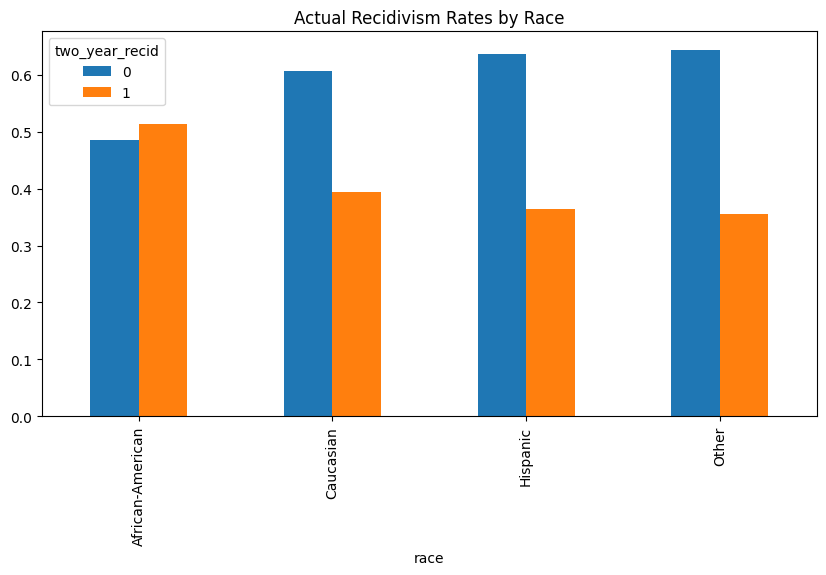

In [8]:
# re-label two races as Other. 
# This is done purely for educational reasons and to avoid addressing issues with a skewed sample in our data
compas_df.loc[compas_df['race'].isin(['Native American', 'Asian']), 'race'] = 'Other'

# plot recidivism rates for the four races we're considering
compas_df.groupby('race')['two_year_recid'].value_counts(
    normalize=True
).unstack().plot(
    kind='bar',
    figsize=(10,5),
    title='Actual Recidivism Rates by Race'
)

<AxesSubplot: title={'center': '% of Charge Degree'}, xlabel='Charge Degree', ylabel='%'>

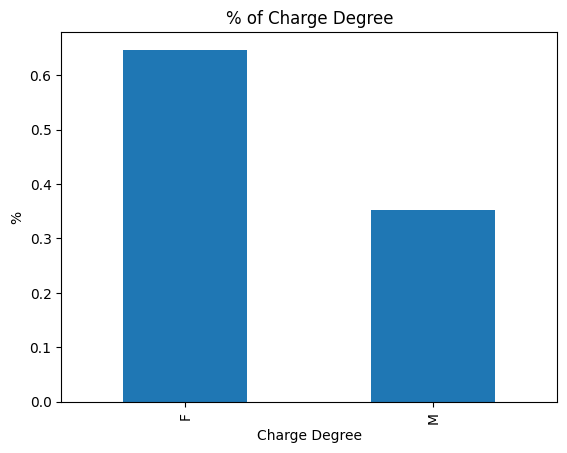

In [9]:
compas_df['c_charge_degree'].value_counts(normalize=True).plot(
    kind='bar', title='% of Charge Degree', ylabel='%', xlabel='Charge Degree' 
)
# F = Felony, M = Misdemeanor

<AxesSubplot: title={'center': 'Histogram of Age'}, ylabel='Frequency'>

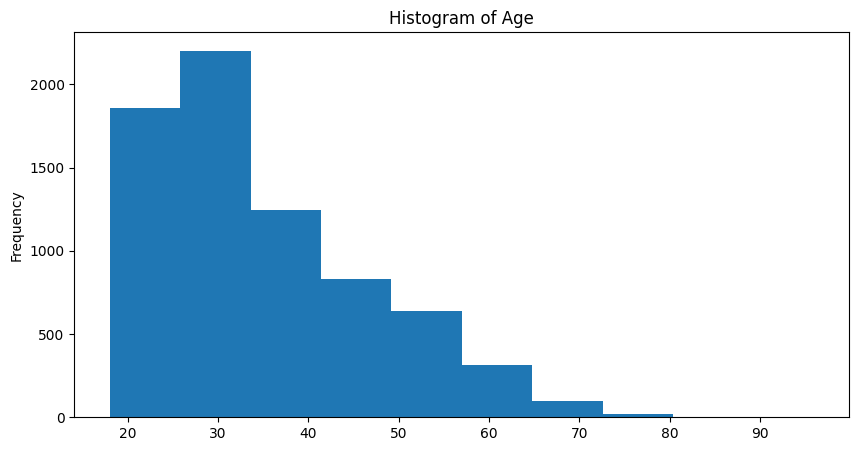

In [10]:
compas_df['age'].plot(
    title='Histogram of Age',
    kind='hist',
    xlabel='Age',
    figsize=(10,5)
)  # right skew on age

<AxesSubplot: title={'center': 'Histograme of Priors Count'}, ylabel='Frequency'>

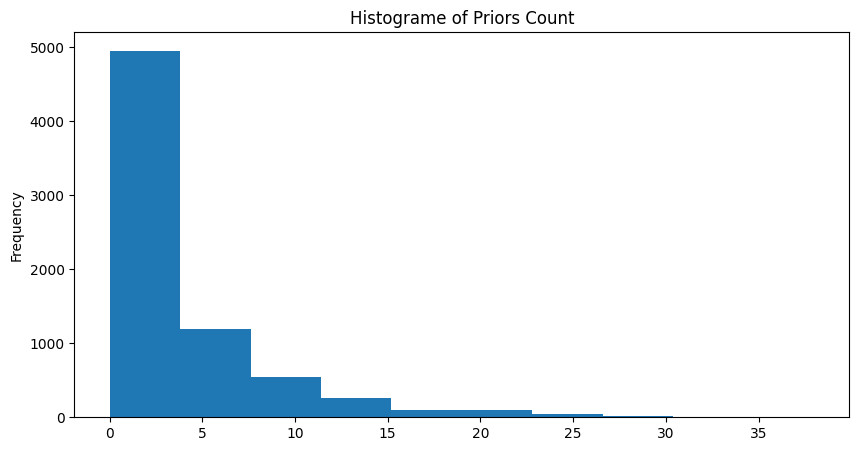

In [11]:
compas_df['priors_count'].plot(
    title='Histograme of Priors Count',
    kind='hist',
    xlabel='Priors',
    figsize=(10,5)
)  # right skew on Priors

# Build Baseline Model and Evaluating Bias

In [12]:
# construct new total juvenile offense count
compas_df['juv_count'] = compas_df[['juv_fel_count', 'juv_misd_count', 'juv_other_count']].sum(axis=1)
# drop original
compas_df = compas_df.drop(['juv_fel_count', 'juv_misd_count', 'juv_other_count'], axis=1)

2023-01-09 18:00:09,542 - Feature Engineering Log - juv_count std: 0.952763227517296
 juv_count mean: 0.2675353479345717)


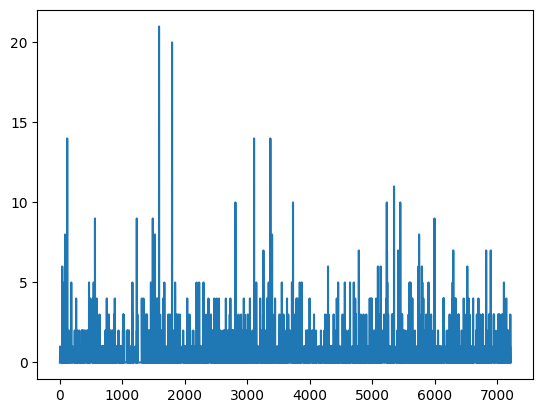

In [13]:
# looking at the new feature
compas_df['juv_count'].plot()
logger.info(
    f'juv_count std: {compas_df["juv_count"].std()}'
    f'\n juv_count mean: {compas_df["juv_count"].mean()})'
)

In [14]:
# train test split
X_train, X_test, y_train, y_test, race_train, race_test = train_test_split(
    compas_df.drop('two_year_recid', axis=1),
    compas_df['two_year_recid'],
    compas_df['race'],
    stratify=compas_df['two_year_recid'],
    test_size=0.3,
    random_state=0
)

# isntantiate RFC
classifier = RandomForestClassifier(max_depth=10, n_estimators=20, random_state=0)

In [15]:
# build feature engineering pipeline
categorical_features = ['race', 'sex', 'c_charge_degree']
categorical_transformer = Pipeline(steps=[
  ('onehot', OneHotEncoder(drop='if_binary'))
])

numerical_features = ['age', 'priors_count']
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

# create preprocessor by putting together these pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

# classifier pipeline
clf_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [16]:
clf_tree.fit(X_train, y_train)
unaware_y_preds = clf_tree.predict(X_test)

In [17]:
exp_tree = dx.Explainer(clf_tree, X_test, y_test, label='Random Forest Bias Unaware', verbose=True)

Preparation of a new explainer is initiated

  -> data              : 2165 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2165 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest Bias Unaware
  -> predict function  : <function yhat_proba_default at 0x13aa55bc0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.444, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.986, mean = 0.00662, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


In [18]:
exp_tree.model_performance()

,recall,precision,f1,accuracy,auc
Random Forest Bias Unaware,0.560451,0.628736,0.592633,0.652656,0.69393


In [19]:
print(classification_report(y_true=y_test, y_pred=unaware_y_preds))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70      1189
           1       0.63      0.56      0.59       976

    accuracy                           0.65      2165
   macro avg       0.65      0.64      0.65      2165
weighted avg       0.65      0.65      0.65      2165



In [20]:
exp_tree.model_parts().plot()

In [21]:
# Recidivism by race in our test set
y_test.groupby(race_test).mean()

race
African-American    0.514652
Caucasian           0.407162
Hispanic            0.327778
Other               0.345324
Name: two_year_recid, dtype: float64

In [22]:
# Predicted Recidivism by race in our bias-unaware model
pd.Series(unaware_y_preds, index=y_test.index).groupby(race_test).mean()

race
African-American    0.508242
Caucasian           0.285146
Hispanic            0.255556
Other               0.381295
dtype: float64

In [23]:
mf_tree = exp_tree.model_fairness(
    protected=race_test, 
    privileged='Caucasian'
)

mf_tree.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
African-American,0.665,0.658,0.674,0.650,0.335,0.342,0.326,0.350,0.662,0.508
Caucasian,0.407,0.799,0.581,0.662,0.593,0.201,0.419,0.338,0.639,0.285
Hispanic,0.356,0.785,0.447,0.714,0.644,0.215,0.553,0.286,0.644,0.261
Other,0.562,0.714,0.509,0.756,0.438,0.286,0.491,0.244,0.662,0.381


In [24]:
# actual recidivism rates
y_test.groupby(race_test).mean()

race
African-American    0.514652
Caucasian           0.407162
Hispanic            0.327778
Other               0.345324
Name: two_year_recid, dtype: float64

In [25]:
# Predicted rates reveal our model is under predicting Caucasian
pd.Series(unaware_y_preds, index=y_test.index).groupby(race_test).mean()

race
African-American    0.508242
Caucasian           0.285146
Hispanic            0.255556
Other               0.381295
dtype: float64

In [26]:
mf_tree = exp_tree.model_fairness(protected=race_test, privileged='Caucasian')

# TPR(r) = TP / AP                           ( aka sensitivity )
# TNR(r) = TN / AN                           ( aka specificity )
# PPV(r) = TP / (PP)                         ( aka precision )
# NPV(r) = TN / (PN)                    
# FNR(r) = FN / AP  OR 1 - TPR                   
# FPR(r) = FP / AN  OR 1 - TNR                   
# FDR(r) = FP / (PP) OR 1 - PPV
# FOR(r) = FN / (PN) OR 1 - NPV         
# ACC(r) = TP + TN  / (TP + TN + FP + FN)    ( Overall accuracy by Race)
# STP(r) = TP + FP / (TP + FP + FP + FN)     ( aka P[recidivism predicted | Race=r] )

mf_tree.fairness_check()

Bias detected in 4 metrics: TPR, PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.633907  1.035994  1.160069  1.701493  1.782456
Hispanic          0.874693  1.007825  0.769363  1.069652  0.915789
Other             1.380835  1.035994  0.876076  1.422886  1.336842


In [27]:
mf_tree.plot()

In [28]:
# manually calculating STP loss
def calc_stp_loss(stps, stp_privilege):
    return sum([np.abs(np.log(stp/stp_privilege)) for stp in stps])

logger.info(f'STP parity loss: {calc_stp_loss(stps=[0.508, 0.261, 0.381], stp_privilege=0.285)}')

2023-01-09 18:00:11,966 - Feature Engineering Log - STP parity loss: 0.956271235113839


In [29]:
# plot of parity loss of each metric
mf_tree.plot(type = 'stacked')

# Building a Bias Aware Model

In [31]:
# find correlation coefficient of numerical features and being African American
compas_df.corrwith(compas_df['race'] == 'African-American').sort_values()

/var/folders/nx/s78sc6913tsf5xq0k1h2_2wr0000gn/T/ipykernel_7269/2891881441.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



age              -0.179095
juv_count         0.111835
two_year_recid    0.131200
priors_count      0.202897
dtype: float64

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,32.740801,10.858391,18.0,25.0,30.0,38.00,77.0
Caucasian,2454.0,37.726569,12.761373,18.0,27.0,35.0,47.75,83.0
Hispanic,637.0,35.455259,11.877783,19.0,26.0,33.0,43.00,96.0
Other,427.0,35.131148,11.634159,19.0,25.0,33.0,43.00,76.0


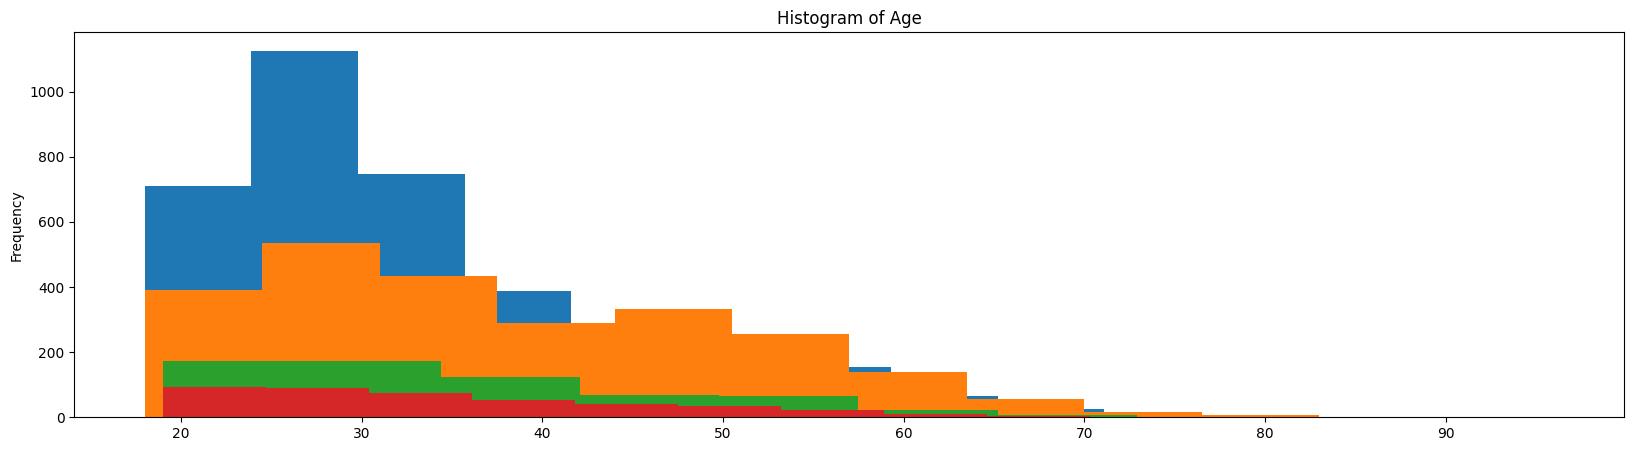

In [34]:
compas_df.groupby('race')['age'].plot(
    figsize=(20,5),
    kind='hist',
    xlabel='Age',
    title='Histogram of Age'
)
compas_df.groupby('race')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,4.438853,5.579835,0.0,1.0,2.0,6.0,38.0
Caucasian,2454.0,2.586797,3.798803,0.0,0.0,1.0,3.0,36.0
Hispanic,637.0,2.252747,3.647673,0.0,0.0,1.0,2.0,26.0
Other,427.0,2.016393,3.695856,0.0,0.0,1.0,2.5,31.0


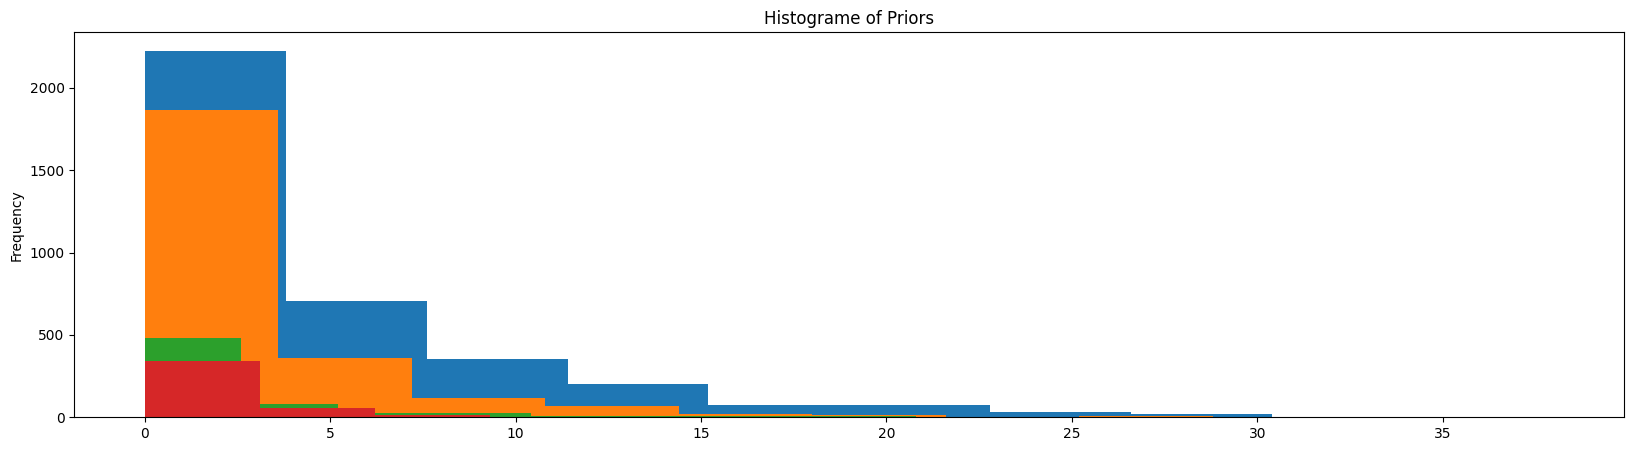

In [35]:
compas_df.groupby('race')['priors_count'].plot(
    figsize=(20,5),
    kind='hist',
    xlabel='Count of Priors',
    title='Histograme of Priors'
)

compas_df.groupby('race')['priors_count'].describe()

In [38]:
# class to implement Yeo-Johnson transformation

class NormalizeColumnByLabel(BaseEstimator, TransformerMixin):
    def __init__(self, col, label) -> None:
        super().__init__()
        self.col = col
        self.label = label
        self.transformers = {}

    def fit(self, X, y=None):
        for group in X[self.label].unique():
            self.transformers[group] = PowerTransformer(
                method='yeo-johnson',
                standardize=True
            )
            self.transformers[group].fit(
                X.loc[X[self.label]==group][self.col].values.reshape(-1, 1)
            )
        return self
        
    def transform(self, X, y=None):
        C = X.copy()
        for group in X[self.label].unique():
            C.loc[X[self.label]==group, self.col] = self.transformers[group].transform(
                X.loc[X[self.label]==group][self.col].values.reshape(-1, 1)
            )
        return C

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,2604.0,-8.868141e-17,1.000192,-1.394037,-0.549932,-0.092417,0.784661,2.276224
Caucasian,1700.0,-1.347941e-16,1.000294,-1.190914,-1.190914,-0.104396,0.733866,2.293665
Hispanic,457.0,-9.911838e-17,1.001096,-1.124116,-1.124116,0.098333,0.620238,2.060623
Other,288.0,1.572816e-16,1.001741,-0.921525,-0.921525,-0.921525,0.878567,1.871600


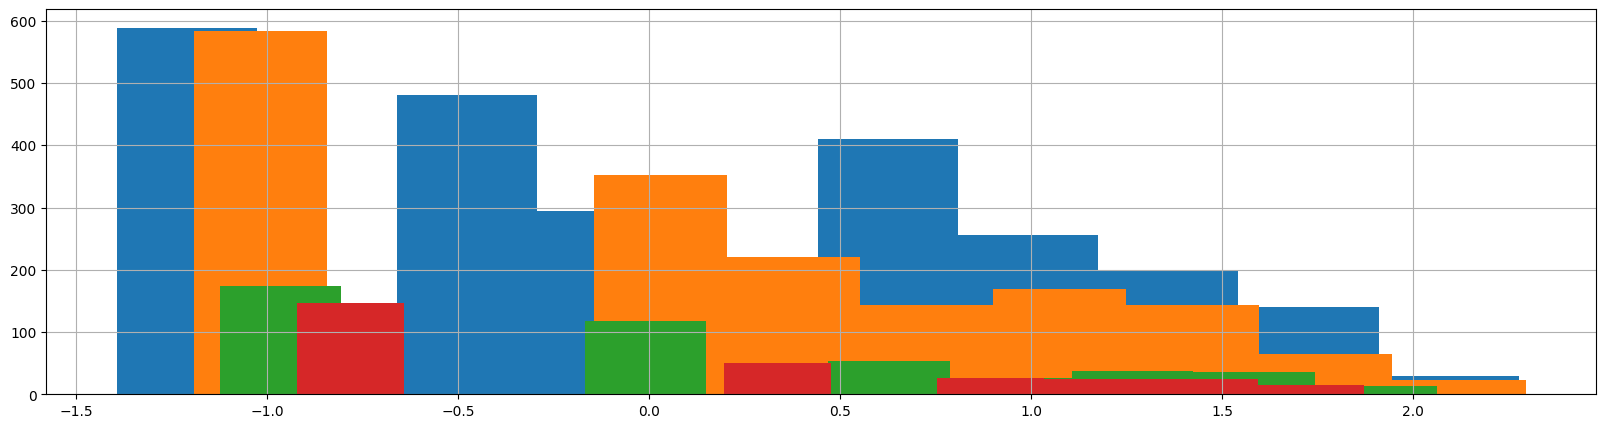

In [39]:
# instantiate class and apply Yeo-Johnson to priors_count
n = NormalizeColumnByLabel(col='priors_count', label='race')

X_train_normalized = n.fit_transform(X_train, y_train)

X_train_normalized.groupby('race')['priors_count'].hist(figsize=(20,5))
X_train_normalized.groupby('race')['priors_count'].describe()

In [40]:
# first bias aware model
clf_tree_aware = Pipeline(steps=[
    ('normalize_priors', NormalizeColumnByLabel(col='priors_count', label='race')),
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

clf_tree_aware.fit(X_train, y_train)
aware_y_preds = clf_tree_aware.predict(X_test)

# check out model performance
exp_tree_aware = dx.Explainer(
    clf_tree_aware, X_test, y_test,
    label='Random Forest DIR', verbose=False
)
mf_tree_aware = exp_tree_aware.model_fairness(
    protected=race_test, privileged='Caucasian'
)

# performance didn't change much
pd.concat([exp.model_performance().result for exp in [exp_tree, exp_tree_aware]])

,recall,precision,f1,accuracy,auc
Random Forest Bias Unaware,0.560451,0.628736,0.592633,0.652656,0.693930
Random Forest DIR,0.560451,0.633835,0.594889,0.655889,0.694199


In [41]:
# Parity loss decreased slightly
mf_tree.plot(objects=[mf_tree_aware], type='stacked')

In [49]:
# feature extraction: learning fair representation implementation using AIF360
class LFRCustom(BaseEstimator, TransformerMixin):
    def __init__(self, col, protected_col, unprivileged_groups, privileged_groups):
        self.col = col
        self.protected_col = protected_col
        self.TR = None
        self.unprivileged_groups = unprivileged_groups
        self.privileged_groups = privileged_groups

    def fit(self, X, y=None):
        d = pd.DataFrame(X, columns=self.col)
        d['response'] = list(y)

        binary_df = BinaryLabelDataset(
            df=d,
            protected_attribute_names=self.protected_col,
            label_names=['response']
        )

        # Parameters set here following textbook, found via offline grid search
        self.TR = LFR(
            unprivileged_groups=self.unprivileged_groups,
            privileged_groups=self.privileged_groups,
            seed=0,
            k=2,
            Ax=0.5,
            Ay=0.2,
            Az=0.2,
            verbose=1
        )

        self.TR.fit(binary_df, maxiter=5000, maxfun=5000)
        return self
    
    def transform(self, X, y=None):
        d = pd.DataFrame(X, columns=self.col)
        if y:
            d['response'] = list(y)
        else:
            d['response'] = False

        binary_df = BinaryLabelDataset(
            df=d,
            protected_attribute_names=self.protected_col,
            label_names=['response']
        )
        return self.TR.transform(binary_df).convert_to_dataframe()[0].drop(['response'], axis=1)

In [50]:
# modify pipeline to use aif transformer
categorical_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ]
)

privileged_groups = [{'Caucasian': 1}]
unprivileged_groups = [{'Caucasian': 0}]

lfr = LFRCustom(
    col=['African-American', 'Caucasian', 'Hispanic', 'Other', 'Male', 'M'],
    protected_col=sorted(X_train['race'].unique()),
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

categorical_pipeline = Pipeline([
    ('transform', categorical_preprocessor),
    ('LFR', lfr)
])

numerical_features = ['age', 'priors_count']
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

numerical_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ]
)

preprocessor = FeatureUnion([
    ('numerical_preprocessor', numerical_preprocessor),
    ('categorical_preprocessor', categorical_pipeline)
])

clf_tree_more_aware = Pipeline(
    steps=[
        ('normalize_priors', NormalizeColumnByLabel(col='priors_count', label='race')),
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ]
)

clf_tree_more_aware.fit(X_train, y_train)

more_aware_y_preds = clf_tree_more_aware.predict(X_test)

step: 0, loss: 0.5113461179394596, L_x: 0.6910353031396581,  L_y: 0.750554787675951,  L_z: 0.07858754417220154
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.11346D-01    |proj g|=  1.09928D-01

At iterate    1    f=  4.46431D-01    |proj g|=  9.33491D-02

At iterate    2    f=  3.06498D-01    |proj g|=  5.18819D-02

At iterate    3    f=  3.03641D-01    |proj g|=  4.65203D-02

At iterate    4    f=  3.00521D-01    |proj g|=  5.46340D-02

At iterate    5    f=  3.00306D-01    |proj g|=  4.84318D-02

At iterate    6    f=  2.99620D-01    |proj g|=  4.82550D-02

At iterate    7    f=  2.98751D-01    |proj g|=  5.28487D-02

At iterate    8    f=  2.94627D-01    |proj g|=  5.02629D-02

At iterate    9    f=  2.89312D-01    |proj g|=  5.09962D-02

At iterate   10    f=  2.80357D-01    |proj g|=  4.56142D-02

At iterate   11    f=  2.65464D-01    |


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [51]:
exp_tree_more_aware = dx.Explainer(
    clf_tree_more_aware, X_test, y_test,
    label='Random Forest DIR + LFR', verbose=False
)

mf_tree_more_aware = exp_tree_more_aware.model_fairness(protected=race_test, privileged='Caucasian')

pd.concat(exp.model_performance().result for exp in [exp_tree, exp_tree_aware, exp_tree_more_aware])

,recall,precision,f1,accuracy,auc
Random Forest Bias Unaware,0.560451,0.628736,0.592633,0.652656,0.693930
Random Forest DIR,0.560451,0.633835,0.594889,0.655889,0.694199
Random Forest DIR + LFR,0.558402,0.639671,0.596280,0.659122,0.693417


In [52]:
mf_tree.plot(objects=[mf_tree_aware, mf_tree_more_aware], type='stacked')
# parity loss decreases after DIR and LFR

In [53]:
mf_tree_more_aware.fairness_check()
# less ratios out of range and only in 3 metrics now

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.626829  1.058268  1.198953  1.538095  1.712329
Hispanic          1.075610  1.102362  0.965096  0.828571  0.893836
Other             0.914634  0.996850  0.806283  1.100000  0.962329
